In [27]:
%matplotlib inline
import random
from skimage import io
from skimage.transform import resize
from collections import defaultdict
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from skimage.feature import hog
import numpy as np
from skimage.transform import pyramid_gaussian

In [28]:
def IOU(A,B):
    x_overlap = max(0, min(B[0],B[2]) - max(A[0],A[2]))
    y_overlap = max(0, min(B[1],B[3]) - max(A[1],A[3]))
    inter = x_overlap * y_overlap;
    
    
#     x1 = max(A[0],B[0])
#     y1 = max(A[1],B[1])
#     x2 = min(A[2],B[2])
#     y2 = min(A[3],B[3])
    
#     w = x2 - x1 + 1
#     h = y2 - y1 + 1
    
#     if w<=0 or h<=0:
#         return 0
    
#     inter = w*h
    
    A_area = (A[2] - A[0] + 1)*(A[3] - A[1] + 1)
    B_area = (B[2] - B[0] + 1)*(B[3] - B[1] + 1)
    
    # print B[0],B[1]
    
    union = (A_area + B_area - inter)*1.0
    inter = inter*1.0
    
    return inter/union

In [31]:
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [34]:
bb_intersection_over_union([0,0,3,3],[1,1,5,5])

0.28125

In [3]:
base_dir = '/home/ayush/GPU_ML/ML/workspace/project/raw/'

win_size = 128


train_x_grp_1_pos = []
train_y_grp_1_pos = []

train_x_grp_2_pos = []
train_y_grp_2_pos = []

train_x_grp_3_pos = []
train_y_grp_3_pos = []

train_x_grp_4_pos = []
train_y_grp_4_pos = []

train_x_grp_5_pos = []
train_y_grp_5_pos = []

train_x_grp_1_neg = []
train_y_grp_1_neg = []

train_x_grp_2_neg = []
train_y_grp_2_neg = []

train_x_grp_3_neg = []
train_y_grp_3_neg = []

train_x_grp_4_neg = []
train_y_grp_4_neg = []

train_x_grp_5_neg = []
train_y_grp_5_neg = []

with open('bounding_boxes.csv','r') as f:
    f.readline()
    for line in f:
        data = line.strip().split(',')
        
        file_name = data[0]
        grp = int(file_name.split('_')[0]) - 1
        
        label_s = data[-1]
        
        x1,y1,x2,y2,label_i = map(int, data[1:])
        
        file_path = base_dir + label_s + '/' + file_name
        img = io.imread(file_path, as_grey = True)
        h,w = img.shape[:2]
        
        #  hand image
        imgg = img[y1:y2,x1:x2]
        imgg = resize(imgg, (win_size,win_size) )
        if grp/4 == 0:
            train_x_grp_1_pos.append(imgg)
            train_y_grp_1_pos.append(1)
        elif grp/2 == 1:
            train_x_grp_2_pos.append(imgg)
            train_y_grp_2_pos.append(1)
        elif grp/2 == 2:
            train_x_grp_3_pos.append(imgg)
            train_y_grp_3_pos.append(1)
        elif grp/2 == 3:
            train_x_grp_4_pos.append(imgg)
            train_y_grp_4_pos.append(1)
        elif grp/2 == 4:
            train_x_grp_5_pos.append(imgg)
            train_y_grp_5_pos.append(1)
        
        
        # non-hand image
        count = 0
        A = [x1,y1,x2,y2]
        
        while True:
            x1_r = random.randrange(0,w - win_size)
            y1_r = random.randrange(0,h - win_size)
            x2_r = x1_r + win_size
            y2_r = y1_r + win_size
            
            if y2_r >= h or x2_r>=w:
                continue
            
            B = [x1_r, y1_r, x2_r, y2_r]
            
            if IOU(A,B) < 0.1:
                if grp/4 == 0:
                    train_x_grp_1_neg.append(img[y1_r:y2_r,x1_r:x2_r])
                    train_y_grp_1_neg.append(0)
                elif grp/4 == 1:
                    train_x_grp_2_neg.append(img[y1_r:y2_r,x1_r:x2_r])
                    train_y_grp_2_neg.append(0)
                elif grp/4 == 2:
                    train_x_grp_3_neg.append(img[y1_r:y2_r,x1_r:x2_r])
                    train_y_grp_3_neg.append(0)
                elif grp/4 == 3:
                    train_x_grp_4_neg.append(img[y1_r:y2_r,x1_r:x2_r])
                    train_y_grp_4_neg.append(0)
                elif grp/4 == 4:
                    train_x_grp_5_neg.append(img[y1_r:y2_r,x1_r:x2_r])
                    train_y_grp_5_neg.append(0)
                
                
                count += 1
            
            if count >= 2:
                break

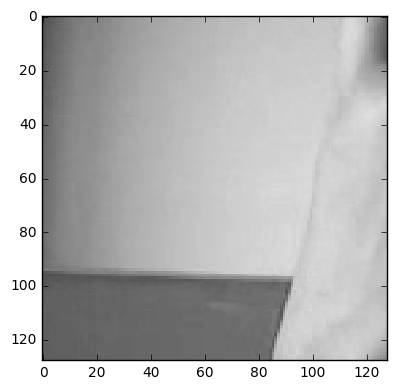

In [4]:
# print train_x_neg[1]
io.imshow(train_x_grp_1_neg[0])

In [5]:
train_x_grp_1_pos_hog = map(lambda x : hog(x), train_x_grp_1_pos)
train_x_grp_2_pos_hog = map(lambda x : hog(x), train_x_grp_2_pos)
train_x_grp_3_pos_hog = map(lambda x : hog(x), train_x_grp_3_pos)
train_x_grp_4_pos_hog = map(lambda x : hog(x), train_x_grp_4_pos)
train_x_grp_5_pos_hog = map(lambda x : hog(x), train_x_grp_5_pos)

train_x_grp_1_neg_hog = map(lambda x : hog(x), train_x_grp_1_neg)
train_x_grp_2_neg_hog = map(lambda x : hog(x), train_x_grp_2_neg)
train_x_grp_3_neg_hog = map(lambda x : hog(x), train_x_grp_3_neg)
train_x_grp_4_neg_hog = map(lambda x : hog(x), train_x_grp_4_neg)
train_x_grp_5_neg_hog = map(lambda x : hog(x), train_x_grp_5_neg)

In [6]:
train_x_1 = train_x_grp_2_pos_hog + train_x_grp_3_pos_hog + train_x_grp_4_pos_hog  \
+ train_x_grp_2_neg_hog + train_x_grp_3_neg_hog + train_x_grp_4_neg_hog

train_y_1 = train_y_grp_2_pos + train_y_grp_3_pos + train_y_grp_4_pos  \
+ train_y_grp_2_neg + train_y_grp_3_neg + train_y_grp_4_neg

val_x_1 = train_x_grp_1_pos_hog + train_x_grp_1_neg_hog
val_y_1 = train_y_grp_1_pos + train_y_grp_1_neg


train_x_2 = train_x_grp_1_pos_hog + train_x_grp_3_pos_hog + train_x_grp_4_pos_hog \
+ train_x_grp_1_neg_hog + train_x_grp_3_neg_hog + train_x_grp_4_neg_hog

train_y_2 = train_y_grp_1_pos + train_y_grp_3_pos + train_y_grp_4_pos  \
+ train_y_grp_1_neg + train_y_grp_3_neg + train_y_grp_4_neg

val_x_2 = train_x_grp_2_pos_hog + train_x_grp_2_neg_hog
val_y_2 = train_y_grp_2_pos + train_y_grp_2_neg


train_x_3 = train_x_grp_1_pos_hog + train_x_grp_2_pos_hog + train_x_grp_4_pos_hog \
+ train_x_grp_1_neg_hog + train_x_grp_2_neg_hog + train_x_grp_4_neg_hog

train_y_3 = train_y_grp_1_pos + train_y_grp_2_pos + train_y_grp_4_pos  \
+ train_y_grp_1_neg + train_y_grp_2_neg + train_y_grp_4_neg

val_x_3 = train_x_grp_3_pos_hog + train_x_grp_3_neg_hog
val_y_3 = train_y_grp_3_pos + train_y_grp_3_neg 


train_x_4 = train_x_grp_1_pos_hog + train_x_grp_2_pos_hog + train_x_grp_3_pos_hog \
+ train_x_grp_1_neg_hog + train_x_grp_2_neg_hog + train_x_grp_3_neg_hog

train_y_4 = train_y_grp_1_pos + train_y_grp_2_pos + train_y_grp_3_pos  \
+ train_y_grp_1_neg + train_y_grp_2_neg + train_y_grp_3_neg

val_x_4 = train_x_grp_4_pos_hog + train_x_grp_4_neg_hog
val_y_4 = train_y_grp_4_pos + train_y_grp_4_neg


In [7]:
clf_1 = svm.LinearSVC()
clf_1.fit(np.asarray(train_x_1),np.asarray(train_y_1))
score_1 = clf_1.score(np.asarray(val_x_1), np.asarray(val_y_1))
print score_1

0.89


In [8]:
clf_2 = svm.LinearSVC()
clf_2.fit(np.asarray(train_x_2),np.asarray(train_y_2))
score_2 = clf_2.score(np.asarray(val_x_2), np.asarray(val_y_2))
print score_2

0.975


In [9]:
clf_3 = svm.LinearSVC()
clf_3.fit(np.asarray(train_x_3),np.asarray(train_y_3))
score_3 = clf_3.score(np.asarray(val_x_3), np.asarray(val_y_3))
print score_3

0.944


In [10]:
clf_4 = svm.LinearSVC()
clf_4.fit(np.asarray(train_x_4),np.asarray(train_y_4))
score_4 = clf_4.score(np.asarray(val_x_4), np.asarray(val_y_4))
print score_4
print 'Average : %f' %((score_1 + score_2 + score_3 + score_4)/4)

0.946
Average : 0.938750


In [7]:
clf_11 = GaussianNB()
clf_11.fit(np.asarray(train_x_1),np.asarray(train_y_1))
score_11 = clf_11.score(np.asarray(val_x_1), np.asarray(val_y_1))
print score_11

0.815


In [8]:
clf_22 = GaussianNB()
clf_22.fit(np.asarray(train_x_2),np.asarray(train_y_2))
score_22 = clf_22.score(np.asarray(val_x_2), np.asarray(val_y_2))
print score_22

0.93


In [9]:
clf_33 = GaussianNB()
clf_33.fit(np.asarray(train_x_3),np.asarray(train_y_3))
score_33 = clf_33.score(np.asarray(val_x_3), np.asarray(val_y_3))
print score_33

0.916


In [10]:
clf_44 = GaussianNB()
clf_44.fit(np.asarray(train_x_4),np.asarray(train_y_4))
score_44 = clf_44.score(np.asarray(val_x_4), np.asarray(val_y_4))
print score_44
print 'Average : %f' %((score_11 + score_22 + score_33 + score_44)/4)

0.964
Average : 0.906250


In [11]:
'Testing using Naive Bayes clf'
val_x_5 = train_x_grp_5_pos_hog + train_x_grp_5_neg_hog
val_y_5 = train_y_grp_5_pos + train_y_grp_5_neg

In [12]:
'To get the scoring based on voting on classes given by the individual classifiers'
def get_class_by_voting(clfs, data):
    classes = defaultdict(int)
    for clf in clfs:
        classes[clf.predict(np.asarray([data]))[0]]=+1

    maxx = 0
    class_ = None
    for cls in classes:
        if classes[cls] > maxx:
            maxx = classes[cls]
            class_ = cls
    if class_ is None:
        print 'Aborting'
        return -1
    
    return class_

In [13]:
def get_class_prob_by_avg(clfs, data):
    classes = np.asarray([0.0, 0.0])
    for clf in clfs:
        classes+=clf.predict_proba(np.asarray([data]))[0]
    classes /= 4
    
    # return the prob. of belonging to class 1
    return classes[1]

In [14]:
def sliding_window(img, clfs):
    # conf_map = np.zeros(img.shape)
    h,w = img.shape[:2]
    stride = 10
    win_size = 128
    X,Y = 0,0
    max_c = 0.0
    for y in range(0,h-win_size+1,stride):
        for x in range(0,w-win_size+1,stride):
            imgg = img[y:y+win_size, x:x+win_size]
            hog_ = hog(imgg)
            class_ = get_class_prob_by_avg(clfs, hog_)
            if class_ > max_c:
                max_c = class_
                X = x
                Y = y
            # for i in range(128):
            #    for j in range(128):
            #        conf_map[y + i][x + j] = max(conf_map[y + i][x + j], class_)
    # return conf_map
    return max_c, Y, X

In [19]:
res = []
for data in val_x_5:
    class_ = get_class_by_voting([clf_1, clf_2, clf_3, clf_4],data)
    if class_ == -1:
        break
    
    res.append(class_)
count = 0

for index in range(len(res)):
    if val_y_5[index] == res[index]:
        count+=1
print 'score : %f' %((count*1.0)/len(res))

score : 0.906000


In [20]:
res = []
for data in val_x_5:
    class_ = get_class_by_voting([clf_11, clf_22, clf_33, clf_44],data)
    if class_ == -1:
        break
    
    res.append(class_)
count = 0

for index in range(len(res)):
    if val_y_5[index] == res[index]:
        count+=1
print 'score : %f' %((count*1.0)/len(res))

score : 0.854000


In [21]:
# print clf_11.predict_proba(val_x_5)
# print val_y_5[499]

In [15]:
test_imgg = io.imread(base_dir + '1/1_31_1_cam1_1_raw.jpg',as_grey=True)
max_score, x, y = sliding_window(test_imgg, [clf_11, clf_22, clf_33, clf_44])
# conf_map_1 = sliding_window(test_imgg, [clf_11, clf_22, clf_33, clf_44])
# io.imshow(conf_map_1)

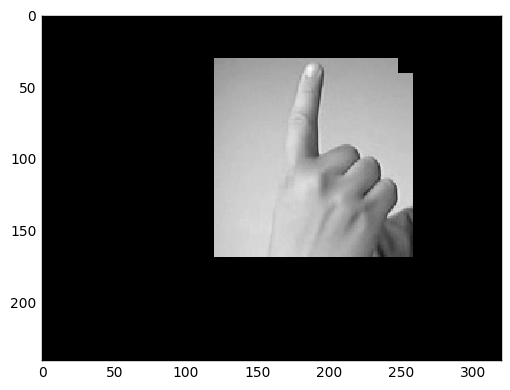

In [23]:
test_imgg1 = test_imgg.copy()
test_imgg1[conf_map_1!=conf_map_1.max()] = 0
io.imshow(test_imgg1)

In [16]:
def get_img_from_pyramid(img, down_scale=1.5):
    py = pyramid_gaussian(img, downscale=down_scale)
    return [py.next(), py.next(), py.next()]

In [17]:
def non_maximal_supression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        for pos in xrange(0, last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            
            overlap = float(w * h) / area[j]
            
            if overlap > overlapThresh:
                suppress.append(pos)
            
        idxs = np.delete(idxs, suppress)

    return boxes[pick]

In [25]:
def multi_scale_search(img, clfs):
    img1, img2, img3 = get_img_from_pyramid(img, down_scale=1.3)
    conf_map_1, x1, y1 = sliding_window(img1, clfs)
    conf_map_2, x2, y2 = sliding_window(img2, clfs)
    conf_map_3, x3, y3 = sliding_window(img3, clfs)
    bbox = [[x1,y1,x1+128,y1+128], [x2,y2,x2+128,y2+128], [x3,y3,x3+128,y3+128]]
    for i in xrange(len(bbox)):
        factor = 1.3**i
        bbox[i] = np.asarray(map(lambda x : int(x*factor), bbox[i]))
    print bbox
    print non_maximal_supression(np.asarray(bbox), 0.1)
    # return [(img1, conf_map_1), (img2, conf_map_2), (img3, conf_map_3)]

In [26]:
multi_scale_search(test_imgg, [clf_11, clf_22, clf_33, clf_44])

[array([ 40, 120, 168, 248]), array([ 26,  91, 192, 257]), array([ 16,  84, 233, 300])]
[[ 16  84 233 300]]


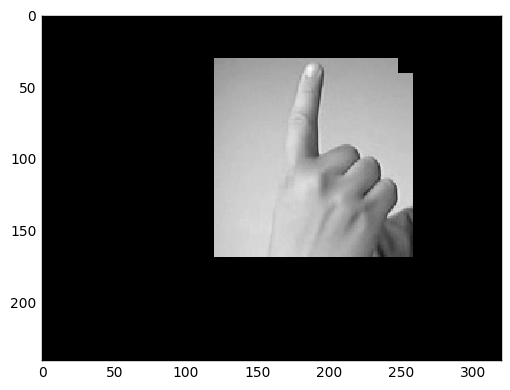

In [27]:
test_imgg1 = conf_maps[0][0].copy()
test_imgg1[conf_maps[0][1]!=conf_maps[0][1].max()] = 0
io.imshow(test_imgg1)

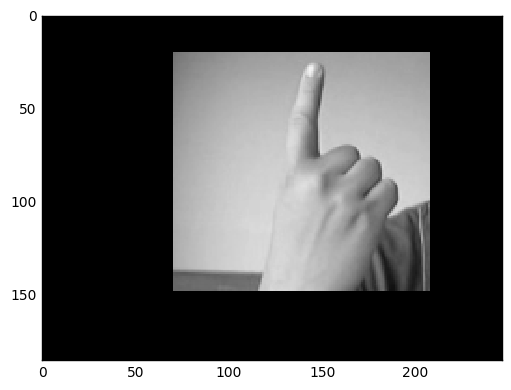

In [28]:
test_imgg2 = conf_maps[1][0].copy()
test_imgg2[conf_maps[1][1]!=conf_maps[1][1].max()] = 0
io.imshow(test_imgg2)

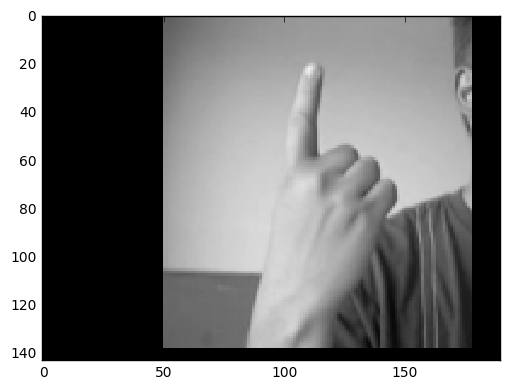

In [29]:
test_imgg3 = conf_maps[2][0].copy()
test_imgg3[conf_maps[2][1]!=conf_maps[2][1].max()] = 0
io.imshow(test_imgg3)

In [30]:
'bringing all the confidence maps to the same dimension'
conf_map_1 = resize(conf_maps[0][1],test_imgg.shape)
conf_map_2 = resize(conf_maps[1][1],test_imgg.shape)
conf_map_3 = resize(conf_maps[2][1],test_imgg.shape)

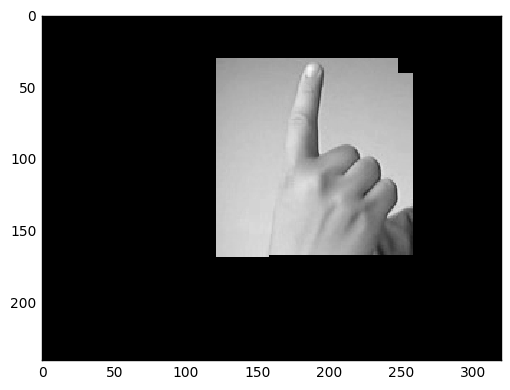

In [31]:
test_imgg1 = test_imgg.copy()
test_imgg1[conf_map_1!=conf_map_1.max()] = 0
io.imshow(test_imgg1)

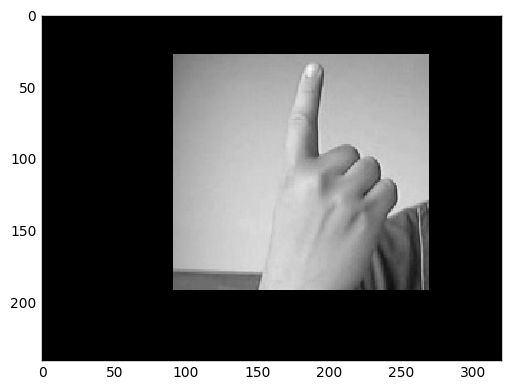

In [32]:
test_imgg2 = test_imgg.copy()
test_imgg2[conf_map_2!=conf_map_2.max()] = 0
io.imshow(test_imgg2)

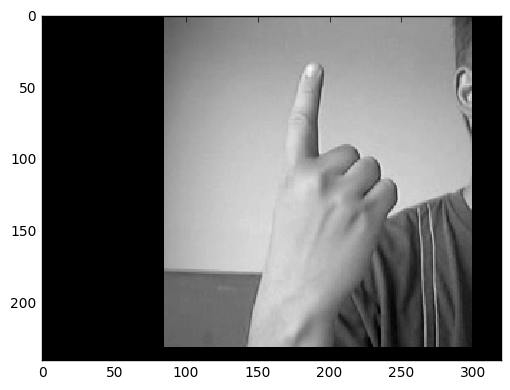

In [33]:
test_imgg3 = test_imgg.copy()
test_imgg3[conf_map_3!=conf_map_3.max()] = 0
io.imshow(test_imgg3)

In [34]:
def get_bounding_box(conf_map):
    a, b = np.where(conf_map==conf_map.max())
    return np.asarray([a[0],b[0],a[1],b[1]])

In [36]:
boxes = []
boxes.append(get_bounding_box(conf_map_1))
boxes.append(get_bounding_box(conf_map_2))
boxes.append(get_bounding_box(conf_map_3))
boxes = np.asarray(boxes)

bbox = non_maximal_supression(boxes, 1.0)

print bbox

[[ 30 121  30 122]
 [ 27  91  27  92]
 [  1  85   1  86]]
